In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
import itertools
import collections
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import csv
import nltk
from nltk import FreqDist
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import re
import spacy
from pprint import pprint 
import seaborn as sns
from nltk.corpus import stopwords
warnings.filterwarnings("ignore") 
%matplotlib inline

In [3]:
training_data = pd.read_csv('train_data.csv')

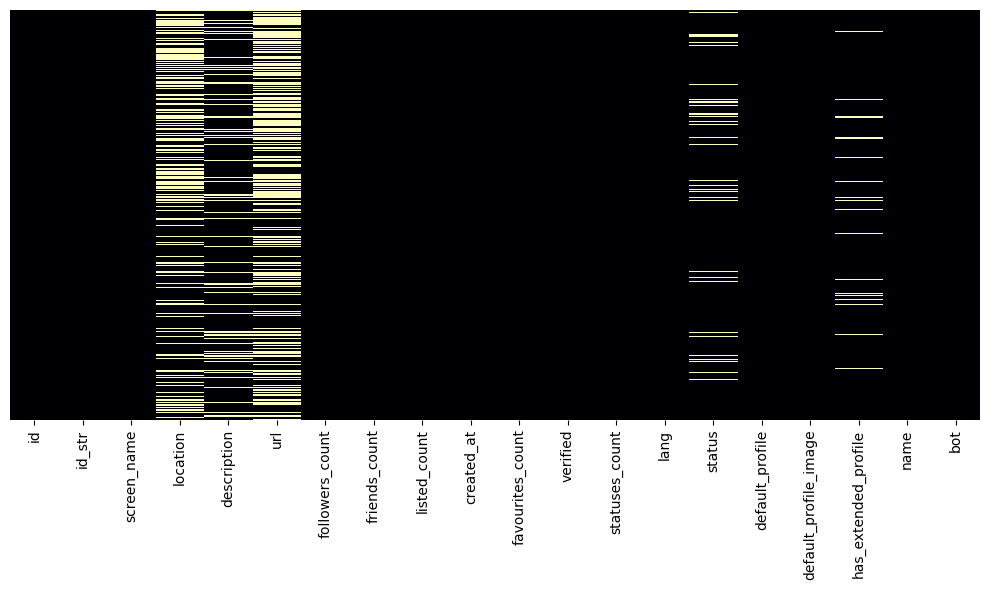

In [4]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='magma')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

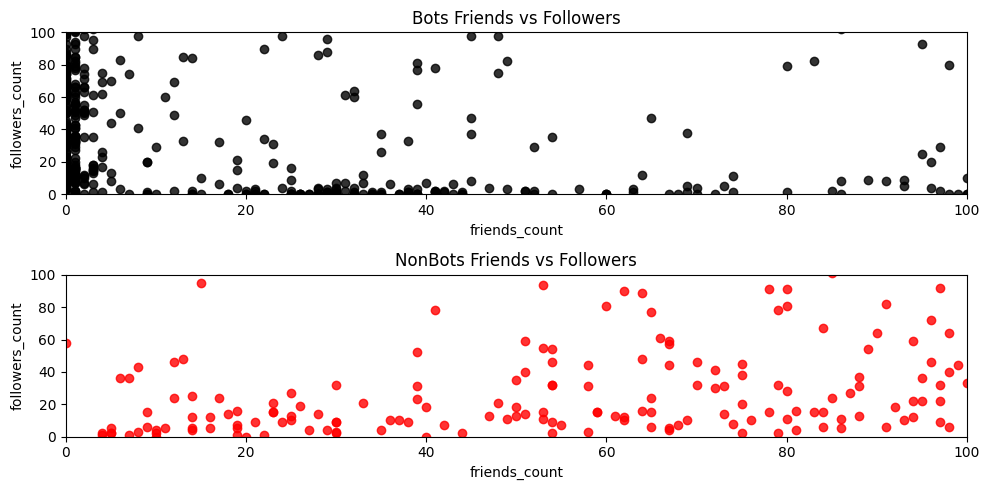

In [5]:
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]

bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(x=bots.friends_count, y=bots.followers_count, color='black', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('NonBots Friends vs Followers')
sns.regplot(x=nonbots.friends_count, y= nonbots.followers_count, color='red', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [6]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(952, 21)

(504, 21)


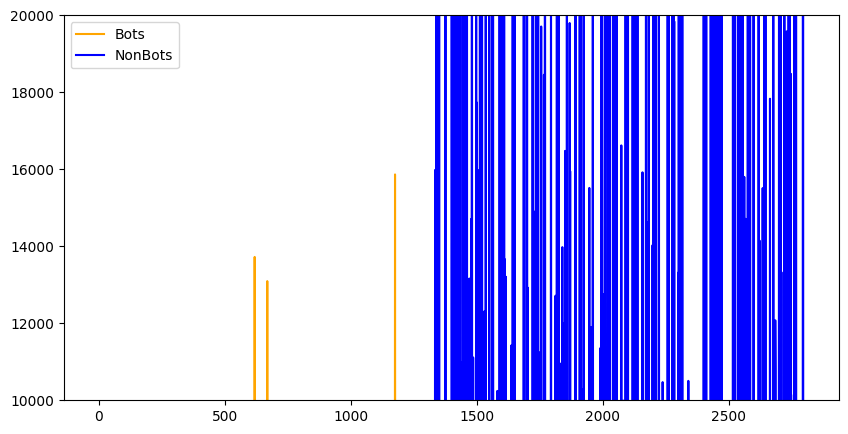

In [7]:
plt.figure(figsize=(10,5))
plt.plot(bots.listed_count, color='orange', label='Bots')
plt.plot(nonbots.listed_count, color='blue', label='NonBots')
plt.legend(loc='upper left')
plt.ylim(10000,20000)
print(bots[(bots.listed_count<5)].shape)

In [8]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

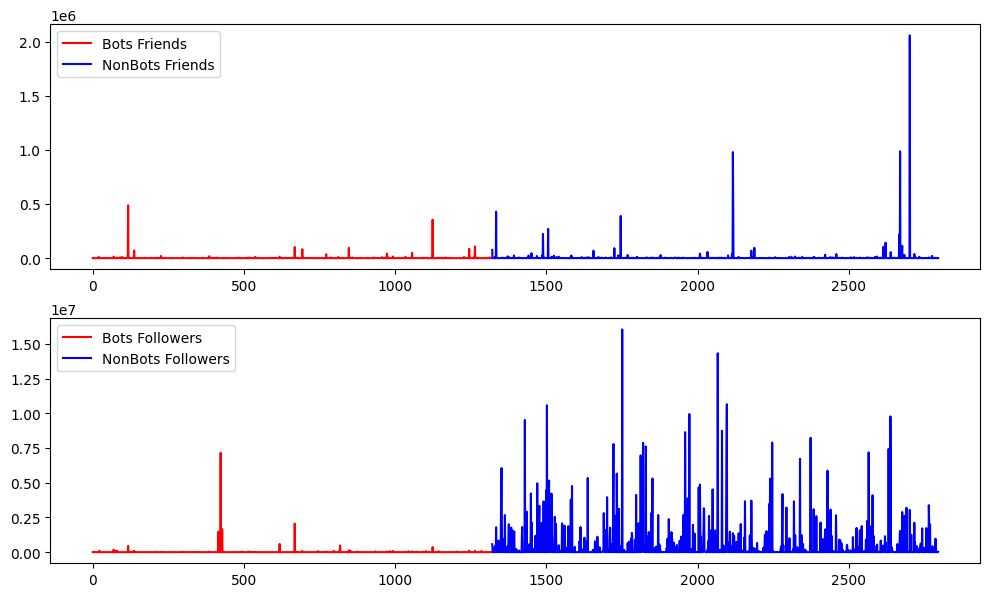

In [9]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='red', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='red', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

In [10]:
#bots[bots.listedcount>10000]
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(1321, 24)

In [11]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(1476, 24)

In [12]:
df = pd.concat([bots, nonbots])
df.shape

(2797, 24)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2797 entries, 0 to 2796
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2797 non-null   float64
 1   id_str                 2797 non-null   object 
 2   screen_name            2797 non-null   object 
 3   location               1777 non-null   object 
 4   description            2394 non-null   object 
 5   url                    1375 non-null   object 
 6   followers_count        2797 non-null   int64  
 7   friends_count          2797 non-null   int64  
 8   listed_count           2797 non-null   int64  
 9   created_at             2797 non-null   object 
 10  favourites_count       2797 non-null   int64  
 11  verified               2797 non-null   bool   
 12  statuses_count         2797 non-null   int64  
 13  lang                   2797 non-null   object 
 14  status                 2461 non-null   object 
 15  default_p

In [14]:
df1 = df[['id','followers_count','friends_count','listed_count','favourites_count','verified','statuses_count','default_profile','default_profile_image','bot','friends_by_followers','screen_name_binary','location_binary','verified_binary']].copy()


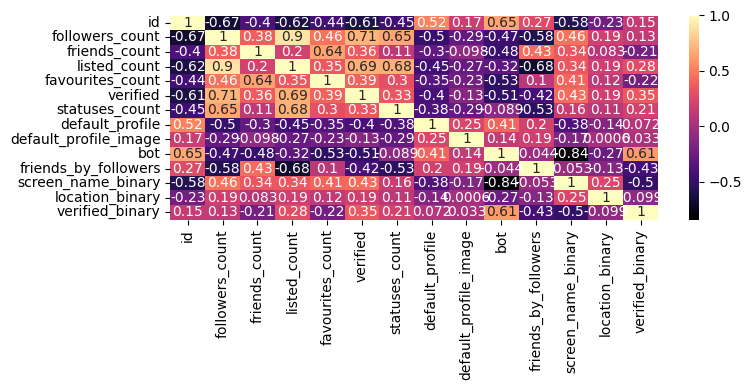

In [15]:
plt.figure(figsize=(8,4))
sns.heatmap(df1.corr(method='spearman'), cmap='magma', annot=True)
plt.tight_layout()
plt.show()

There is no correlation between id, statuses_count, default_profile, default_profile_image and target variable.
There is strong correlation between verified, listed_count, friends_count, followers_count and target variable.
We cannot perform correlation for categorical attributes. So we will take screen_name, name, description, status into feature engineering. While use verified, listed_count for feature extraction.

In [16]:
stop_words = stopwords.words('english')
def remove_stopwords(rev):
    rev_new =[]
    for sentence in rev:
        for word in sentence:
            #rev_new_word = []
            if word not in stop_words:
                rev_new.append(word)
        #rev_new.append(rev_new_word)
    return rev_new

In [16]:
df1.head()

,id,followers_count,friends_count,listed_count,favourites_count,verified,statuses_count,default_profile,default_profile_image,bot,friends_by_followers,screen_name_binary,location_binary,verified_binary
0,8.160000e+17,1291,0,10,0,False,78554,True,False,1,0.000000,False,False,True
1,4.843621e+09,1,349,0,38,False,31,True,False,1,349.000000,False,False,True
2,4.303727e+09,1086,0,14,0,False,713,True,False,1,0.000000,True,True,True
3,3.063139e+09,33,0,8,0,False,676,True,True,1,0.000000,False,True,True
4,2.955142e+09,11,745,0,146,False,185,False,False,1,67.727273,False,False,True


In [17]:
tweets_data = []
x = []
y = []
dataset = []
all_words = []
vectorizer = CountVectorizer(stop_words='english')

def retrieveProcessedData(Pdata_url,row_num):
    with open(Pdata_url, 'r', encoding="latin-1") as csvfile:
        csvreader = csv.reader(csvfile)
        c = 0
        for row in csvreader:
            #replace characters
            if row[19] == '0':
                continue
            y = row[row_num]
            if(len(y)==0):
                continue
            if(c==1):
                print(y)
            c = c+1
            if(c == 10000):
                break
            y = re.sub('[^A-Za-z0-9 ]+', '', y)
            y = y.replace("@", "")
            y = y.replace("n\'t", " not")
            #remove links
            y = re.sub(r"http\S+", "", y)
            #remove words less than 2
            y = re.sub(r'\b\b', '', y)
            #Lowercase
            y = y.lower()
            x.append(y)

In [18]:
def freq_words(x, terms = 50):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  #dash = dict(sorted(words_df.items(), key=lambda item: item[1]))
  #dash = sorted(words_df.items(), key=lambda x: x[1], reverse=True)
 # print(words_df)
  #sorted_dict = collections.OrderedDict(words_df)
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  
  bag_array = d['word'].to_numpy()
  #print(bag_array)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()
  return bag_array

In [19]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    #print(output)
    return output

In [20]:
def preprocessing():
    tokenized_reviews = pd.Series(x).apply(lambda t: t.split())
    reviews = lemmatization(tokenized_reviews)
    reviews_3 = []
    for i in range(len(reviews)):
        reviews_3.append(' '.join(reviews[i]))
    dataset = reviews_3
    bag_array = []
    bag_array = freq_words(dataset, 20)
   # print(bag_array)
    s = ''
    for ele in bag_description :
        s += ele
        s += '|'
    s = s[:-1] 
    return s

In [21]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


"HoustonPokeMap"


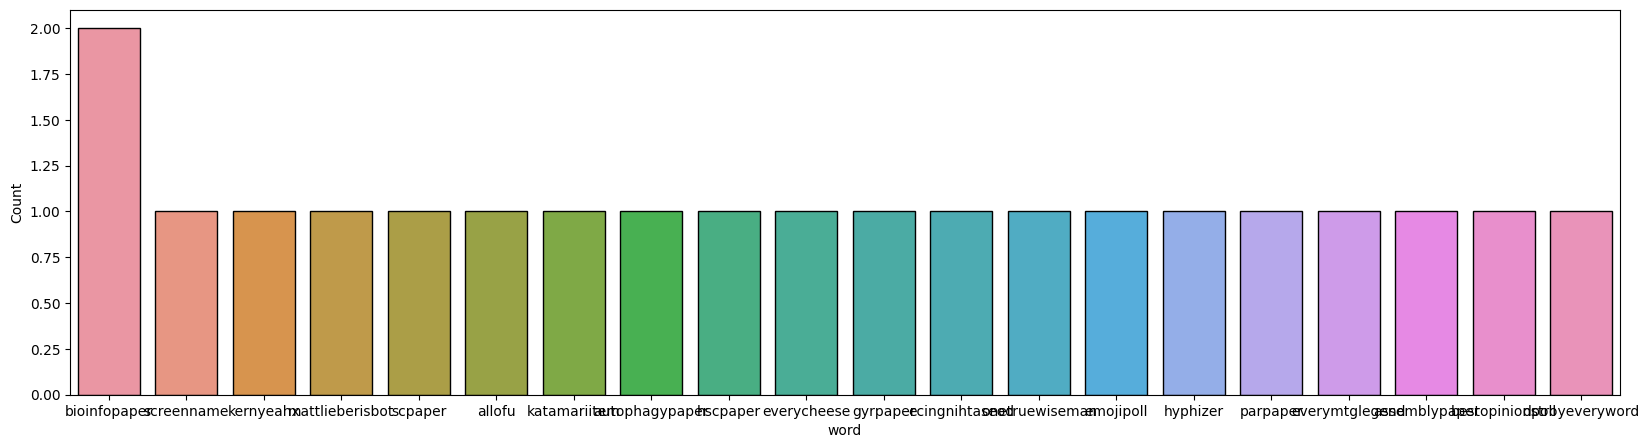

"Rare and strong PokÅ½mon in Houston, TX. See more PokÅ½mon at https://t.co/dnWuDbFRkt"


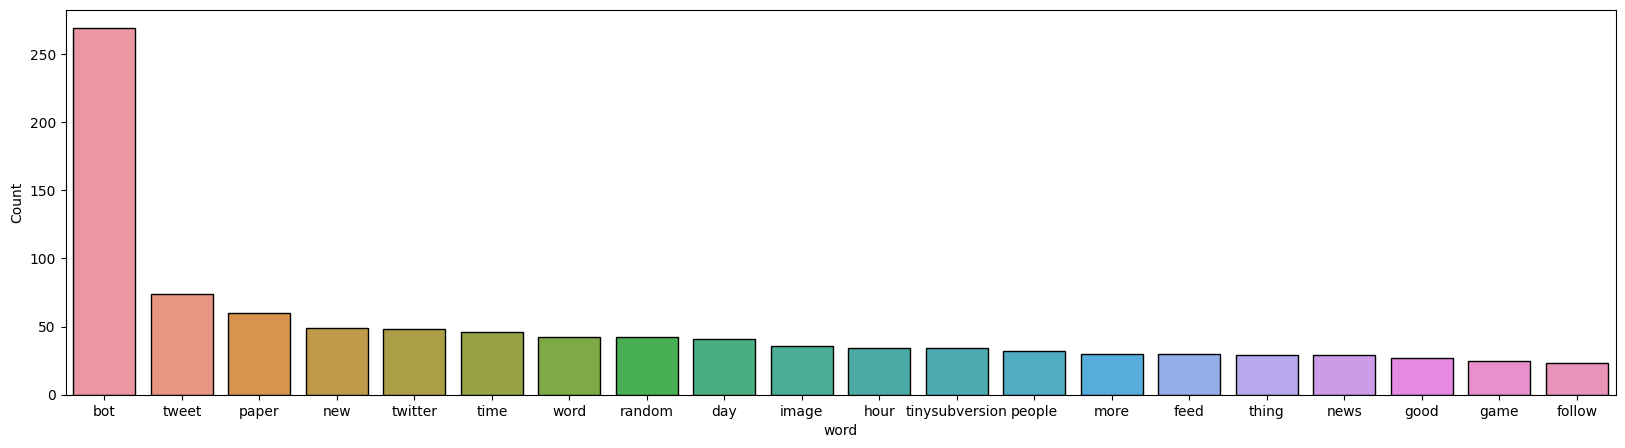

{
      "created_at": "Sun Mar 12 15:44:04 +0000 2017",
      "id": 840951532543737900,
      "id_str": "840951532543737856",
      "text": "[Southeast Houston] Chansey (F) (IV: 73%) until 11:11:37AM at 2511 Winbern St https://t.co/HYRIyq4mF7 https://t.co/bydOOKsEEI",
      "truncated": false,
      "entities":  {
        "hashtags":  [],
        "symbols":  [],
        "user_mentions":  [],
        "urls":  [
           {
            "url": "https://t.co/HYRIyq4mF7",
            "expanded_url": "https://houstonpokemap.com/#29.73067033,-95.36610821",
            "display_url": "houstonpokemap.com/#29.73067033,-Ã",
            "indices":  [
              78,
              101
            ]
          },
           {
            "url": "https://t.co/bydOOKsEEI",
            "expanded_url": "https://maps.google.com/maps?q=29.73067033,-95.36610821",
            "display_url": "maps.google.com/maps?q=29.7306Ã",
            "indices":  [
              102,
              125
            ]
  

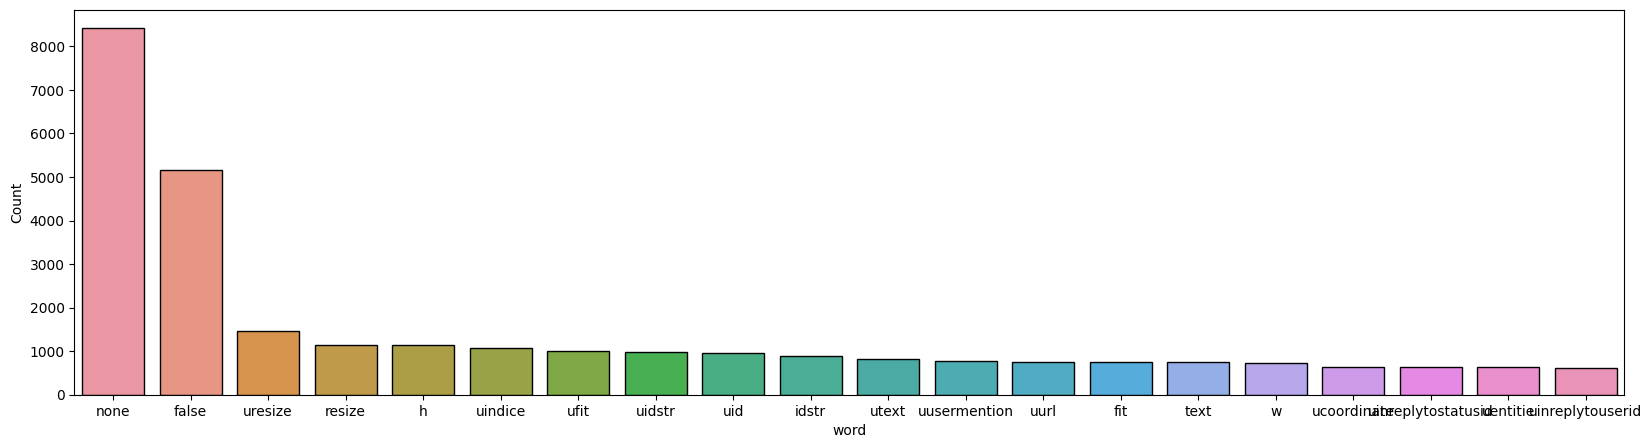

"Houston PokÅ½ Alert"


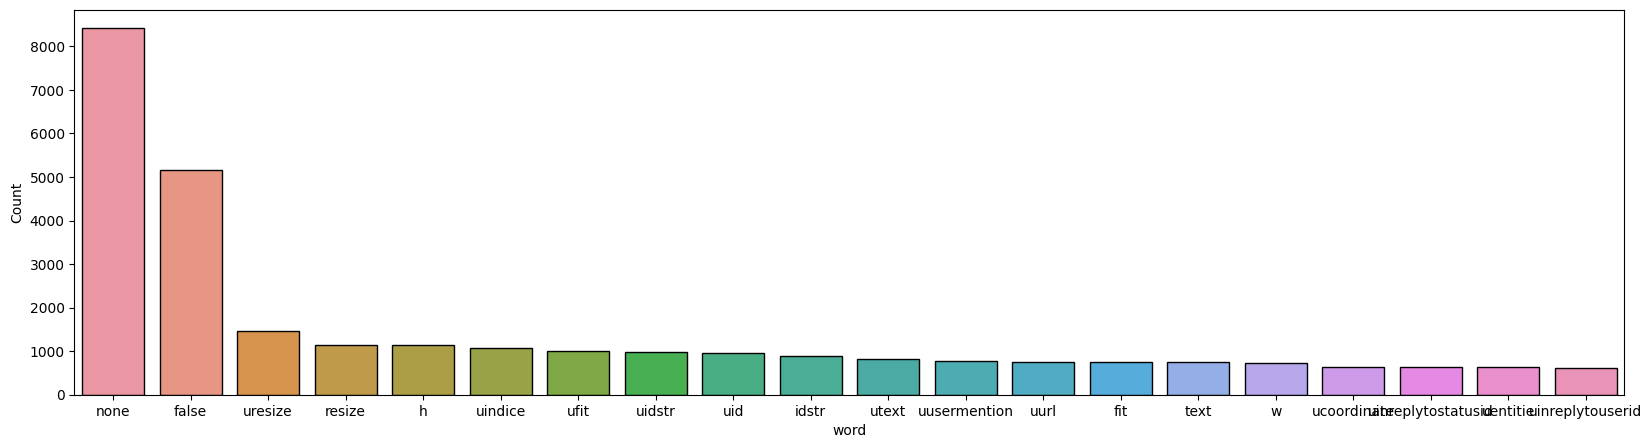

In [22]:
bag_description = [] #4
bag_screen_name = [] #2
bag_name = [] #18
bag_status = [] #14

#s = ''

def runall():
    # retrieveTweet('data/tweetdata.txt')
   
    retrieveProcessedData('train_data.csv',2)
    s = preprocessing()
    #print("this is s :", s)
    training_data['screen_name_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    
    retrieveProcessedData('train_data.csv',4)
    s = preprocessing()
    #print("description s", s)
    training_data['description_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    retrieveProcessedData('train_data.csv',14)
    s = preprocessing()
    training_data['status_binary'] = training_data.description.str.contains(s, case=False, na=False)
    
    retrieveProcessedData('train_data.csv',18)
    
    # remove stopwords from the text
    #data = [remove_stopwords(r.split()) for r in x]
    # make entire text lowercase
    #data = [r.lower() for r in data]
    s = preprocessing()
    training_data['name_binary'] = training_data.description.str.contains(s, case=False, na=False)
runall()

In [23]:
training_data['screen_name_binary']
training_data['name_binary']
training_data['description_binary']
training_data['status_binary']

0        True
1        True
2        True
3       False
4        True
        ...  
2792     True
2793     True
2794     True
2795     True
2796     True
Name: status_binary, Length: 2797, dtype: bool

In [24]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

In [49]:
""" from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
#X_train = X
#y_train = y
dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print("Training Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test)) """

Training Accuracy: 0.86868
Test Accuracy: 0.86667


In [25]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

In [26]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [27]:
def find_best_split(X, y):
    best_info_gain = -np.inf
    best_feature = None
    best_threshold = None

    n_features = X.shape[1]
    for feature in range(n_features):
        unique_values = np.unique(X[:, feature])
        for threshold in unique_values:
            left_indices = np.where(X[:, feature] <= threshold)[0]
            right_indices = np.where(X[:, feature] > threshold)[0]

            info_gain = calculate_info_gain(y, left_indices, right_indices)
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold

In [28]:
def calculate_info_gain(y, left_indices, right_indices):
    p = len(left_indices) / len(y)
    q = len(right_indices) / len(y)
    info_gain = entropy(y) - p * entropy(y[left_indices]) - q * entropy(y[right_indices])
    return info_gain

In [29]:
def build_tree(X, y, depth=0, max_depth=10, min_samples_leaf=50, min_samples_split=10):
    if depth == max_depth or len(y) < min_samples_split or len(np.unique(y)) == 1:
        label = np.argmax(np.bincount(y))
        return Node(label=label)

    feature, threshold = find_best_split(X, y)
    if threshold is None:
        label = np.argmax(np.bincount(y))
        return Node(label=label)

    left_indices = np.where(X[:, feature] <= threshold)[0]
    right_indices = np.where(X[:, feature] > threshold)[0]

    if len(left_indices) < min_samples_leaf or len(right_indices) < min_samples_leaf:
        label = np.argmax(np.bincount(y))
        return Node(label=label)

    left = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth, min_samples_leaf, min_samples_split)
    right = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth, min_samples_leaf, min_samples_split)

    return Node(feature=feature, threshold=threshold, left=left, right=right)


In [30]:
def predict(x, tree):
    if tree.label is not None:
        return tree.label

    if x[tree.feature] <= tree.threshold:
        return predict(x, tree.left)
    else:
        return predict(x, tree.right)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = training_data[features].iloc[:, :-1].values
y = training_data[features].iloc[:, -1].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Train the decision tree
dt = build_tree(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = np.array([predict(x, dt) for x in X_train])
y_pred_test = np.array([predict(x, dt) for x in X_test])

# Calculate and print the accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Training Accuracy: %.5f" % train_accuracy)
print("Test Accuracy: %.5f" % test_accuracy)

Training Accuracy: 0.85335
Test Accuracy: 0.84881


In [32]:
def print_tree(node, depth=0):
    if node.label is not None:
        print(depth * '  ', 'Label:', node.label)
    else:
        print(depth * '  ', 'Feature:', node.feature, 'Threshold:', node.threshold)
        print_tree(node.left, depth + 1)
        print_tree(node.right, depth + 1)

print('Decision Tree Structure:')
print_tree(dt)

Decision Tree Structure:
 Feature: 4 Threshold: False
   Feature: 6 Threshold: 46
     Feature: 7 Threshold: 57
       Label: 1
       Feature: 6 Threshold: 6
         Feature: 5 Threshold: 261
           Label: 1
           Label: 1
         Label: 1
     Feature: 5 Threshold: 9
       Feature: 6 Threshold: 237
         Label: 1
         Label: 1
       Feature: 6 Threshold: 1587
         Label: 0
         Label: 1
   Label: 0


In [35]:
sample = ['Bradly', 'Bradley Matthew', 'Professional Chemist', 'Check out this new video on sulphuric acid production', True, 5000, 1000, 2000, True]
prediction = predict(sample, dt)
if prediction == 0:
    msg = 'Not a bot'
elif prediction ==1:
    msg = 'Bot'

print("Prediction:", msg)

Prediction: Not a bot
